In [1]:
import pandas as pd
import numpy as np
from glob import glob
import xarray as xr
import matplotlib.pyplot as plt
from scipy.stats import linregress
from scipy import stats
from scipy.stats.kde import gaussian_kde
import os
import geopandas as gpd
from shapely.geometry import mapping
os.chdir('/Users/zeqinhuang/Documents/paper/HW_track')

from matplotlib.patches import Rectangle
import matplotlib as mpl
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyproj import transform
from cnmaps import get_adm_maps, clip_contours_by_map
from cnmaps.drawing import draw_map
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature
import cmaps
import shapefile
import matplotlib.path as mpath
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

/var/folders/gl/305lw9j910n_yd3gdvyjpyz80000gn/T/ipykernel_17905/123347715.py:8: DeprecationWarning: Please use `gaussian_kde` from the `scipy.stats` namespace, the `scipy.stats.kde` namespace is deprecated.
  from scipy.stats.kde import gaussian_kde
/Users/zeqinhuang/miniforge3/envs/threeDMap/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
senarios = ['historical','hist-aer','hist-GHG','hist-nat','ssp585','piControl']
fns = pd.read_csv('data/CMIP6_file_names.txt',header=None,sep='_')
fns.columns = ['var','freq','model','senario','run','grid','time']
fns['file_name'] = fns.apply(lambda x: '_'.join(x), axis=1)

In [3]:
senario_model_run = {}
for s in senarios:
    fns_s = fns[fns['senario']==s]
    modles_s = np.unique(fns_s['model'])
    model_run = {}
    for m in modles_s:
        fns_s_m = fns_s[fns_s['model']==m]
        run_s_m = fns_s_m['run'].tolist()
        model_run[m] = run_s_m
    senario_model_run[s] = model_run

In [44]:
def _compute_slope(var):
    """
    Private function to compute slopes at each grid cell using
    linregress. 
    """
    isnan = np.isnan(var)
    var = var[np.logical_not(isnan)]
    slp = linregress(range(len(var)),var).slope
    return slp

def _compute_sig(var):
    """
    Private function to compute slopes at each grid cell using
    linregress. 
    """
    sig = linregress(range(len(var)),var).pvalue
    return sig

def trend_cal(data):
    """
    Computes linear slope (m) at each grid cell.
    
    Args:
        da: xarray DataArray to compute slopes for
        
    Returns:
        xarray DataArray with slopes computed at each grid cell.
    """

    slopes = xr.apply_ufunc(_compute_slope,
                            data,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['time']],
                            output_dtypes=[float],
                            )
    sig = xr.apply_ufunc(_compute_sig,
                            data,
                            vectorize=True,
                            dask='parallelized', 
                            input_core_dims=[['time']],
                            output_dtypes=[float],
                            )
    return slopes,sig

def sel_domain(dataarray,lon_min,lon_max,lat_min,lat_max):
    mask_lon = (dataarray.lon >= lon_min) & (dataarray.lon <= lon_max)
    mask_lat = (dataarray.lat >= lat_min) & (dataarray.lat <= lat_max)
    dataarray = dataarray.where(mask_lon & mask_lat, drop=True)
    return dataarray

target_griddes = {'lat':np.arange(15,56,1),'lon':np.arange(70,141,1)}
def regrid(raw):
    data_interp = raw.interp(lat=target_griddes['lat'],lon=target_griddes['lon'],method='nearest')
    data_interp = data_interp.interpolate_na(dim=('lon'),method='linear',fill_value='extrapolate')
    return data_interp

def cal_area_weighted_mean(dataarray):
    try:
        dataarray = dataarray.rename({'latitude':'lat','longitude':'lon'})
    except:
        pass
    weights = np.cos(np.deg2rad(dataarray.lat))
    weights.name = 'weights'
    da_weighted = dataarray.weighted(weights)
    da_ts = da_weighted.mean(('lon','lat'))
    return da_ts

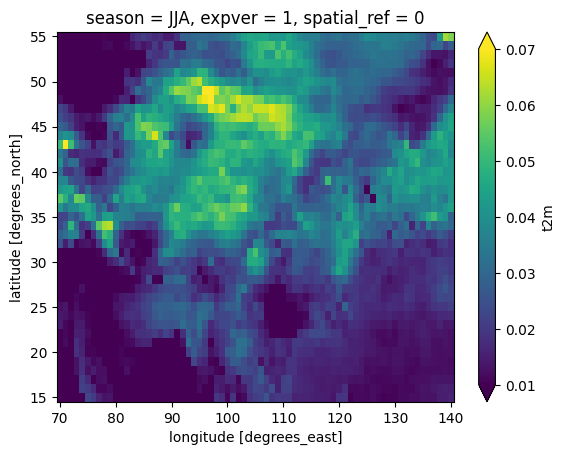

In [27]:
era5_t2m_summer = xr.open_dataarray('/Users/zeqinhuang/Documents/paper/HW_track/data/t2m_summer_1979_2022_era5.nc')
era5_t2m_summer = era5_t2m_summer.rename({'longitude':'lon','latitude':'lat'})
era5_t2m_summer.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)
era5_t2m_summer.rio.write_grid_mapping(inplace=True)
era5_t2m_summer.rio.write_crs("epsg:4326", inplace=True)
china_shp = gpd.read_file('shapefiles/country.shp')
era5_t2m_summer_clip = era5_t2m_summer.rio.clip(china_shp.geometry.apply(mapping),drop=True)
era5_slope, era5_sig = trend_cal(era5_t2m_summer)
era5_slope.plot(vmin=0.01,vmax=0.07)

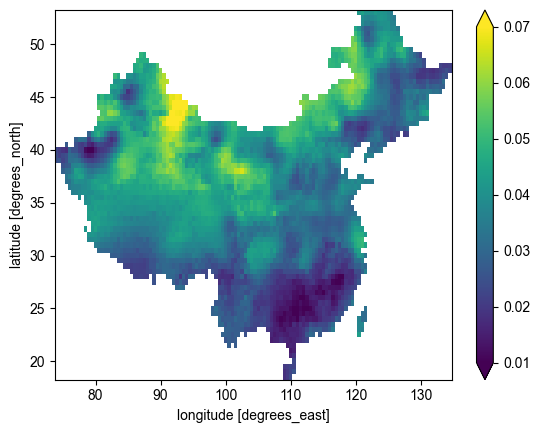

In [43]:
t2m_mean_HRLT_1979_2019 = xr.open_dataarray('/Volumes/Seagate_HZQ/reanalyses/HRLT/China_025deg_meantmp_1979-2019.nc')
HRLT_slope, HRLT_sig = trend_cal(t2m_mean_HRLT_1979_2019)
HRLT_slope.plot(vmin=0.01,vmax=0.07)
plt.show()

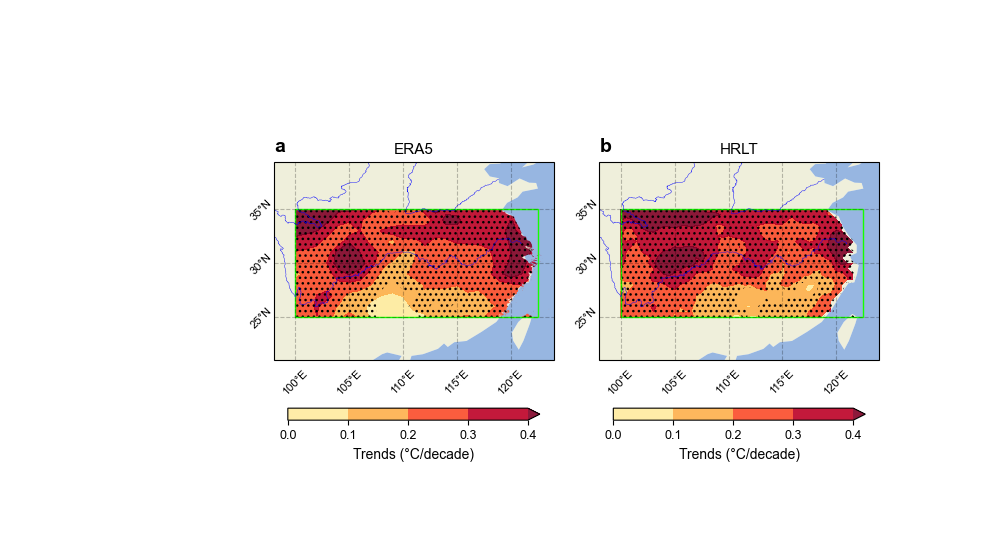

In [50]:
from copy import copy
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

source_path = 'shapefiles/country.shp'
Path = mpath.Path
sfile = shapefile.Reader(source_path)
for shape_rec in sfile.shapeRecords():
    vertices = []
    codes = []
    pts = shape_rec.shape.points
    prt = list(shape_rec.shape.parts) + [len(pts)]
    for i in range(len(prt) - 1):
        for j in range(prt[i], prt[i+1]):
            vertices.append((pts[j][0], pts[j][1]))
        codes += [Path.MOVETO]
        codes += [Path.LINETO] * (prt[i+1] - prt[i] -2)
        codes += [Path.CLOSEPOLY]
    clip = mpath.Path(vertices, codes)
    clip = mpatches.PathPatch(clip,visible=False,transform=ccrs.PlateCarree())
    
fig = plt.figure(figsize = (7,4))
mapcrs = ccrs.PlateCarree()

axes_locs = [
    [0.05,0.1,0.4,0.8],
    [0.515,0.1,0.4,0.8],
]

# ax1 
ax1 = fig.add_axes(axes_locs[0],projection=mapcrs)
clip_copy = copy(clip)
ax1.add_patch(clip_copy)
river = shpreader.Reader('shapefiles/yangtze_yellow_river.shp')
river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', lw=0.3)
ax1.add_feature(cfeature.LAND.with_scale('110m'))
ax1.add_feature(cfeature.OCEAN.with_scale('110m'))
ax1.add_feature(river_feature)
ax1.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,))
china = get_adm_maps(level='国')
draw_map(china,color='black',linewidth=0.5)
era5_slope_YRB = era5_slope.sel(lat = slice(35,25),lon = slice(100,125))
era5_slope_YRB = era5_slope_YRB * 10
era5_sig_YRB = era5_sig.sel(lat = slice(35,25),lon = slice(100,125)) < 0.05
lon = era5_slope_YRB['lon']
lat = era5_slope_YRB['lat']
p1 = ax1.contourf(lon, lat, era5_slope_YRB, cmap=cmaps.MPL_YlOrRd, levels=[0,0.1,0.2,0.3,0.4],extend = 'max', transform=ccrs.PlateCarree(),alpha=0.9)
p2 = ax1.contourf(
    lon, lat, era5_sig_YRB,
    transform=ccrs.PlateCarree(),
    colors='none',
    edgecolor='gray',
    levels=[.5, 1.5],
    hatches=['...',None],
    linewidth=1
)
for c in p1.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)
for c in p2.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)

ax1.set_title('ERA5',fontdict={'fontsize':11,'fontweight': 'medium'},y=1)
fig_cbar = fig.colorbar(p1, ax=ax1, location='bottom', shrink = 0.9, extend = 'max')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('Trends (°C/decade)',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

gl1 = ax1.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.25, linestyle='--', draw_labels=True)
ax1.set_extent([98, 124, 21, 39])
gl1.ylocator = mticker.FixedLocator([25,30,35])
gl1.xformatter = LONGITUDE_FORMATTER
gl1.yformatter = LATITUDE_FORMATTER
gl1.xlabel_style = {'rotation': 45, 'ha':'center','fontsize':8}
gl1.ylabel_style = {'rotation': 45, 'ha':'center','fontsize':8}
gl1.right_labels = False
gl1.top_labels = False

# ax2 
ax2 = fig.add_axes(axes_locs[1],projection=mapcrs)
clip_copy = copy(clip)
ax2.add_patch(clip_copy)
river_feature = ShapelyFeature(river.geometries(), ccrs.PlateCarree(), facecolor='none', edgecolor='blue', lw=0.3)
ax2.add_feature(cfeature.LAND.with_scale('110m'))
ax2.add_feature(cfeature.OCEAN.with_scale('110m'))
ax2.add_feature(river_feature)
ax2.add_patch(Rectangle((100,25),width=22.5,height=10,fc='none',color='#16FF00',linewidth=1,))
china = get_adm_maps(level='国')
draw_map(china,color='black',linewidth=0.5)
HRLT_slope_YRB = HRLT_slope.sel(lat = slice(35,25),lon = slice(100,125))
HRLT_slope_YRB = HRLT_slope_YRB * 10
HRLT_sig_YRB = HRLT_sig.sel(lat = slice(35,25),lon = slice(100,125)) < 0.05
lon = HRLT_slope_YRB['lon']
lat = HRLT_slope_YRB['lat']
p1 = ax2.contourf(lon, lat, HRLT_slope_YRB, cmap=cmaps.MPL_YlOrRd, levels=[0,0.1,0.2,0.3,0.4],extend = 'max', transform=ccrs.PlateCarree(),alpha=0.9)
p2 = ax2.contourf(
    lon, lat, HRLT_sig_YRB,
    transform=ccrs.PlateCarree(),
    colors='none',
    edgecolor='gray',
    levels=[.5, 1.5],
    hatches=['...',None],
    linewidth=1
)
for c in p1.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)
for c in p2.collections:
    c.set_clip_path(clip_copy)
    c.set_rasterized(True)

ax2.set_title('HRLT',fontdict={'fontsize':11,'fontweight': 'medium'},y=1)
fig_cbar = fig.colorbar(p1, ax=ax2, location='bottom', shrink = 0.9, extend = 'max')
fig_cbar.ax.tick_params(labelsize=9)
fig_cbar.set_label('Trends (°C/decade)',fontdict={'fontsize': 10, 'fontweight': 'medium'})
fig_cbar.ax.xaxis.set_tick_params(which='minor', bottom=False) # remove minor ticks of the colorbar

gl2 = ax2.gridlines(crs=ccrs.PlateCarree(), x_inline=False, y_inline=False, linewidth=0.8, color='black', alpha=0.25, linestyle='--', draw_labels=True)
ax2.set_extent([98, 124, 21, 39])
gl2.ylocator = mticker.FixedLocator([25,30,35])
gl2.xformatter = LONGITUDE_FORMATTER
gl2.yformatter = LATITUDE_FORMATTER
gl2.xlabel_style = {'rotation': 45, 'ha':'center','fontsize':8}
gl2.ylabel_style = {'rotation': 45, 'ha':'center','fontsize':8}
gl2.right_labels = False
gl2.top_labels = False


def add_panel_label(ax, label, x = -0.1, y = 1):
    ax.text(x, y, label, transform=ax.transAxes,
      fontsize=14, fontweight='bold', va='top', ha='left')

add_panel_label(ax1, 'a', x=0, y = 1.12)
add_panel_label(ax2, 'b', x=0, y = 1.12)

plt.tight_layout()
plt.show()
fig.savefig("Figures/Fig9_SAT_trend_ERA5_vs_HRLT.pdf")
fig.savefig('Figures/Fig9_SAT_trend_ERA5_vs_HRLT.png')